### Импорты

In [1]:
import os
import numpy as np
import time
import memory_profiler
import functools
import math
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from matplotlib.gridspec import GridSpec
import polars as pl
from functools import reduce

### Задание 1. Сравнительный анализ производительности NumPy и чистого Python

In [69]:
def generate_test_datasets() -> dict[str, np.array]:
    return {
        'small': np.random.random(1000),
        'medium': np.random.random(10000),
        'large': np.random.random(100000),
        'xlarge': np.random.random(1000000)
        }

In [2]:
def benchmark(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        _ = func(*args, **kwargs)
        end_time = time.time()
        #   аргумент retval=True позволит вренуть результат вычислений
        #       но это может исказить точное значение времени выполнения исходной функции
        memory_usage = memory_profiler.memory_usage((func, args, kwargs), max_usage=True)

        return {
            'time': end_time - start_time,
            'max_memory': memory_usage,
        }
    return wrapper

In [71]:
@benchmark
def py_square(data):
    return [x ** 2 for x in data]

@benchmark
def np_square(data):
    return np.square(data)

@benchmark
def py_sin(data):
    return [math.sin(x) for x in data]

@benchmark
def np_sin(data):
    return np.sin(data)

@benchmark
def py_sum(data):
    return sum(data)

@benchmark
def np_sum(data):
    return np.sum(data)

@benchmark
def py_max(data):
    return max(data)

@benchmark
def np_max(data):
    return np.max(data)

In [ ]:
#   при первом запуске функции происходит компиляция,
#       что может исказить результаты замеров времени выполнения
#       (при первом запуске numpy уступает по скорости чистому python)

def benchmark_operations():
    datasets = generate_test_datasets()
    operations = [
        py_square,
        np_square,
        py_sin,
        np_sin,
        py_sum,
        np_sum,
        py_max,
        np_max
    ]
    all_results = {}
    for name, data in datasets.items():
        for operation in operations:
            operation_results = all_results.setdefault(operation.__name__, {})
            operation_results[name] = operation(data)

    return all_results

In [73]:
benchmark_reslults = benchmark_operations()

In [74]:
benchmark_reslults

{'py_square': {'small': {'time': 0.0008692741394042969,
   'max_memory': 237.16796875},
  'medium': {'time': 0.0013880729675292969, 'max_memory': 238.01953125},
  'large': {'time': 0.013671398162841797, 'max_memory': 245.5078125},
  'xlarge': {'time': 0.1547391414642334, 'max_memory': 351.20703125}},
 'np_square': {'small': {'time': 2.1696090698242188e-05,
   'max_memory': 237.16796875},
  'medium': {'time': 3.981590270996094e-05, 'max_memory': 234.6796875},
  'large': {'time': 0.0001316070556640625, 'max_memory': 238.5703125},
  'xlarge': {'time': 0.0017390251159667969, 'max_memory': 266.24609375}},
 'py_sin': {'small': {'time': 0.0001704692840576172,
   'max_memory': 237.16796875},
  'medium': {'time': 0.001123189926147461, 'max_memory': 234.6796875},
  'large': {'time': 0.012008428573608398, 'max_memory': 245.5078125},
  'xlarge': {'time': 0.12671208381652832, 'max_memory': 351.90234375}},
 'np_sin': {'small': {'time': 2.5510787963867188e-05,
   'max_memory': 237.16796875},
  'mediu

In [75]:
rows = []
for func, sizes in benchmark_reslults.items():
    for size, metrics in sizes.items():
        rows.append({
            'function': func,
            'size': size,
            'time': metrics['time'],
            'memory': metrics['max_memory']
        })

df = pd.DataFrame(rows)

In [76]:
df.head()

,function,size,time,memory
0,py_square,small,0.000869,237.167969
1,py_square,medium,0.001388,238.019531
2,py_square,large,0.013671,245.507812
3,py_square,xlarge,0.154739,351.207031
4,np_square,small,0.000022,237.167969


In [77]:
# Упорядочиваем размеры
size_order = ['small', 'medium', 'large', 'xlarge']
df['size'] = pd.Categorical(df['size'], categories=size_order, ordered=True)
df = df.sort_values(['function', 'size'])

# Создаем график для времени выполнения
fig_time = go.Figure()

# Цвета для функций
colors = {
    'py_square': '#FF6B6B',
    'np_square': '#4ECDC4',
    'py_sin': '#FFD166',
    'np_sin': '#06D6A0',
    'py_sum': '#118AB2',
    'np_sum': '#EF476F',
    'py_max': '#073B4C',
    'np_max': '#7209B7'
}

# Добавляем trace для каждой функции
for func in df['function'].unique():
    func_data = df[df['function'] == func]
    fig_time.add_trace(go.Bar(
        name=func,
        x=func_data['size'],
        y=func_data['time'],
        marker_color=colors.get(func, 'gray'),
        text=[f'{t:.6f}' for t in func_data['time']],
        textposition='auto',
    ))

fig_time.update_layout(
    title='Время выполнения функций по размерам данных',
    xaxis_title='Размер данных',
    yaxis_title='Время (сек)',
    barmode='group',
    yaxis_type='log',  # Логарифмическая шкала для наглядности
    height=600,
    showlegend=True
)

fig_time.show()

In [78]:
size_order = ['small', 'medium', 'large', 'xlarge']
df['size'] = pd.Categorical(df['size'], categories=size_order, ordered=True)
df = df.sort_values(['function', 'size'])

# Создаем график для времени выполнения
fig_time = go.Figure()

# Цвета для функций
colors = {
    'py_square': '#FF6B6B',
    'np_square': '#4ECDC4',
    'py_sin': '#FFD166',
    'np_sin': '#06D6A0',
    'py_sum': '#118AB2',
    'np_sum': '#EF476F',
    'py_max': '#073B4C',
    'np_max': '#7209B7'
}

# Добавляем trace для каждой функции
for func in df['function'].unique():
    func_data = df[df['function'] == func]
    fig_time.add_trace(go.Bar(
        name=func,
        x=func_data['size'],
        y=func_data['memory'],
        marker_color=colors.get(func, 'gray'),
        text=[f'{t:.6f}' for t in func_data['memory']],
        textposition='auto',
    ))

fig_time.update_layout(
    title='Затраты памяти на выполнения функций по размерам данных',
    xaxis_title='Размер данных',
    yaxis_title='Память',
    barmode='group',
    yaxis_type='linear',
    height=600,
    showlegend=True
)

fig_time.show()

In [114]:
# Строим сводную таблицу времени выполнения
pivot_time = df.pivot_table(index='function', columns='size', values='time', observed=True)

# Вычисляем ускорение (speedup) для каждой функции и размера
speedup_data = []
sizes = list(pivot_time.columns)
functions = list(set(map(lambda x: x.split("_")[1], pivot_time.index)))

for func in functions:
    row = []
    for size in sizes:
        py_time = pivot_time.loc[f'py_{func}', size]
        np_time = pivot_time.loc[f'np_{func}', size]
        speedup = py_time / np_time if np_time > 0 else 0
        row.append(speedup)
    speedup_data.append(row)

# Создаем DataFrame для тепловой карты
speedup_df = pd.DataFrame(speedup_data, index=functions, columns=sizes)

fig = go.Figure(data=go.Heatmap(
    z=speedup_df.values,
    x=speedup_df.columns,
    y=speedup_df.index,
    text=np.round(speedup_df.values, 2),
    texttemplate='%{text}',
    textfont={"size": 16},
    colorscale = 'ylgn',
    hoverongaps=False,
    hovertemplate='<b>Функция</b>: %{y}<br>' +
                  '<b>Размер</b>: %{x}<br>' +
                  '<b>Ускорение</b>: %{z:.2f}x<br>' +
                  '<extra></extra>',))
# Настраиваем макет
fig.update_layout(
    title={
        'text': 'Тепловая карта относительного ускорения NumPy над чистым Python',
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title="Размер данных",
    yaxis_title="Функция",
)

fig.show()

### 2. Анализ и визуализация данных с pandas и seaborn

In [3]:
df = sns.load_dataset('titanic')

In [4]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [6]:
df.isna().sum(axis=0)

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

<Axes: >

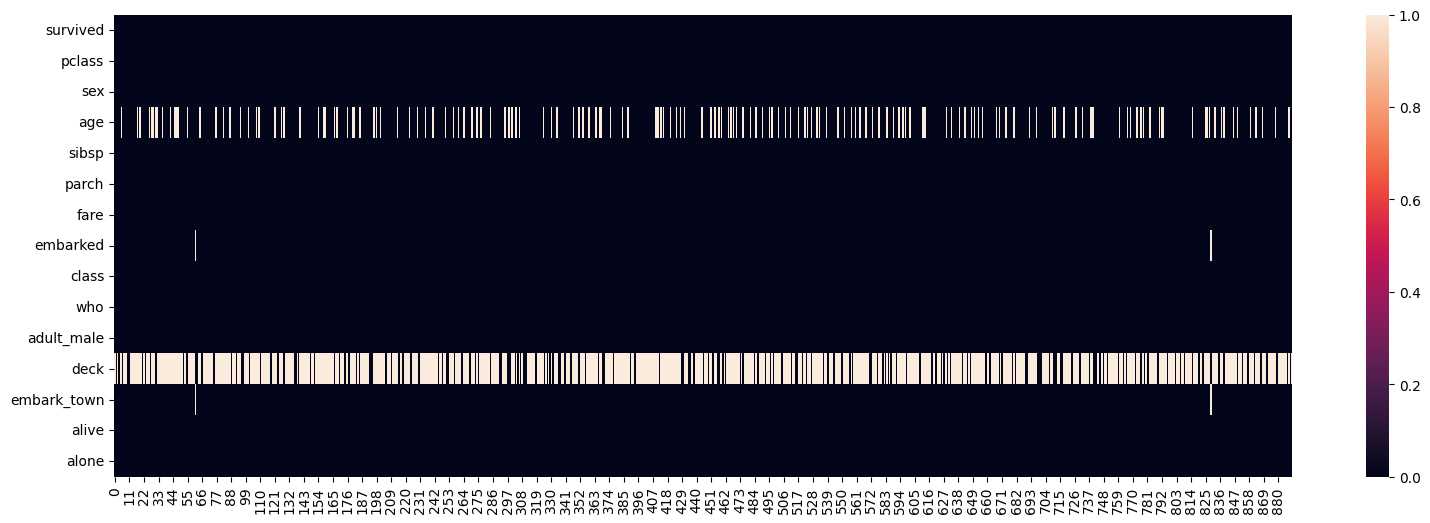

In [7]:
plt.figure(figsize=(19, 6))
sns.heatmap(df.isna().transpose())

In [8]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
pivot_sex_pclass_1 = df.groupby(['sex', 'pclass']).agg(
    survived_count = ('survived', 'sum'),
    total_count = ('survived', 'count')
)
pivot_sex_pclass_1

survived_count  total_count
sex    pclass                             
female 1                   91           94
       2                   70           76
       3                   72          144
male   1                   45          122
       2                   17          108
       3                   47          347

In [10]:
def calc_stats(group):
    return pd.Series({
        'total_count': len(group),
        'survived_count': group['survived'].sum(),
        'not_survived_count': len(group) - group['survived'].sum(),
        'survived_rate %': (group['survived'].sum() / len(group) * 100).round(1)
    })

pivot_sex_pclass_2 = df.groupby(['sex', 'pclass']).apply(calc_stats, include_groups=False)
pivot_sex_pclass_2

total_count  survived_count  not_survived_count  \
sex    pclass                                                    
female 1              94.0            91.0                 3.0   
       2              76.0            70.0                 6.0   
       3             144.0            72.0                72.0   
male   1             122.0            45.0                77.0   
       2             108.0            17.0                91.0   
       3             347.0            47.0               300.0   

               survived_rate %  
sex    pclass                   
female 1                  96.8  
       2                  92.1  
       3                  50.0  
male   1                  36.9  
       2                  15.7  
       3                  13.5

In [11]:
def create_features(df):
    # Добавим возрастные группы
    df['age_groupe'] = pd.cut(df['age'],
                              bins=[0, 18, 30, 50, 100],
                              labels=['child', 'young', 'adult', 'senior'])

    # Добавим размер семьи
    df['family_size'] = df['sibsp'] + df['parch']

    return df

In [12]:
df = create_features(df)

In [13]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,age_groupe,family_size
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,young,1
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,adult,1
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,young,0
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,adult,1
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,adult,0


In [2]:
n = 1_000_000
benchmark_df = pd.DataFrame({
    'string': np.random.choice(['A', 'B', 'C', 'D', 'E'], n),
    'int': np.random.randint(1, 100, n),
    'float': np.random.uniform(0, 1, n),
})
benchmark_df['category'] = benchmark_df['string'].astype('category')
benchmark_df['string_pyarrow'] = benchmark_df['string'].astype('string[pyarrow]')
benchmark_df['int_pyarrow'] = benchmark_df['int'].astype('int64[pyarrow]')
benchmark_df['float_pyarrow'] = benchmark_df['float'].astype('float64[pyarrow]')

In [5]:
rows = []
for col in benchmark_df.columns:
    res = benchmark_df[col].memory_usage(deep=True)
    rows.append({
        'column': col,
        'memory': res
        })

memory_usage_df = pd.DataFrame(rows)
memory_usage_df

,column,memory
0,string,50000132
1,int,4000132
2,float,8000132
3,category,1000554
4,string_pyarrow,9000132
5,int_pyarrow,8000132
6,float_pyarrow,8000132


In [3]:
num_cols = ['int', 'float', 'int_pyarrow', 'float_pyarrow']

In [4]:
str_cols = ['string', 'category', 'string_pyarrow']

In [5]:
benchmark_df.head()

,string,int,float,category,string_pyarrow,int_pyarrow,float_pyarrow
0,A,27,0.772160,A,A,27,0.77216
1,A,59,0.887289,A,A,59,0.887289
2,C,46,0.704506,C,C,46,0.704506
3,D,11,0.923364,D,D,11,0.923364
4,E,16,0.056120,E,E,16,0.05612


In [6]:
benchmark_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype          
---  ------          --------------    -----          
 0   string          1000000 non-null  object         
 1   int             1000000 non-null  int32          
 2   float           1000000 non-null  float64        
 3   category        1000000 non-null  category       
 4   string_pyarrow  1000000 non-null  string         
 5   int_pyarrow     1000000 non-null  int64[pyarrow] 
 6   float_pyarrow   1000000 non-null  double[pyarrow]
dtypes: category(1), double[pyarrow](1), float64(1), int32(1), int64[pyarrow](1), object(1), string(1)
memory usage: 43.9+ MB


In [7]:
print("Класс массива для 'string':", type(benchmark_df['string']._values))
print("Класс массива для 'string_pyarrow':", type(benchmark_df['string_pyarrow']._values))

Класс массива для 'string': <class 'numpy.ndarray'>
Класс массива для 'string_pyarrow': <class 'pandas.core.arrays.string_arrow.ArrowStringArray'>


In [10]:
@benchmark
def test_unique(df: pd.DataFrame, col):
    return df[col].unique()

@benchmark
def test_sort(df: pd.DataFrame, col):
    return df.sort_values(col)

@benchmark
def test_value_count(df: pd.DataFrame, col):
    return df[col].value_counts()

@benchmark
def test_sum(df: pd.DataFrame, col):
    if col not in num_cols:
        return
    return df[col].sum()

@benchmark
def test_max(df: pd.DataFrame, col):
    if col not in num_cols:
        return
    return df[col].max()

@benchmark
def test_mean(df: pd.DataFrame, col):
    if col not in num_cols:
        return
    return df[col].mean()

@benchmark
def test_median(df: pd.DataFrame, col):
    if col not in num_cols:
        return
    return df[col].median()

@benchmark
def test_std(df: pd.DataFrame, col):
    if col not in num_cols:
        return
    return df[col].std()

@benchmark
def test_vec_mul(df: pd.DataFrame, col):
    if col not in num_cols:
        return
    return df[col] * 100

@benchmark
def test_contains(df: pd.DataFrame, col):
    if col not in str_cols:
        return
    return df[col].str.contains('A')

@benchmark
def test_startswith(df: pd.DataFrame, col):
    if col not in str_cols:
        return
    return df[col].str.startswith('A')

In [11]:
def benchmark_operations_df(df: pd.DataFrame):
    operations = [
        test_unique,
        test_sort,
        test_value_count,
        test_sum,
        test_max,
        test_mean,
        test_median,
        test_std,
        test_vec_mul,
        test_contains,
        test_startswith
    ]

    rows = []
    for operation in operations:
        for col in df.columns:
            res = operation(df, col)
            rows.append({
                'function': operation.__name__,
                'column': col,
                'time': res['time'],
                'memory': res['max_memory']
                })

    return pd.DataFrame(rows)

In [12]:
benchmark_df_res = benchmark_operations_df(benchmark_df)

In [13]:
benchmark_df_res

,function,column,time,memory
0,test_unique,string,3.698087e-02,264.277344
1,test_unique,int,7.260561e-03,256.691406
2,test_unique,float,6.403565e-02,304.253906
3,test_unique,category,7.074833e-03,257.011719
4,test_unique,string_pyarrow,1.484489e-02,257.070312
...,...,...,...,...
72,test_startswith,float,1.192093e-06,340.167969
73,test_startswith,category,4.331350e-03,348.757812
74,test_startswith,string_pyarrow,1.123309e-02,343.980469
75,test_startswith,int_pyarrow,4.053116e-06,336.664062


In [18]:
# Создаем график для времени выполнения
fig_time = go.Figure()

# Цвета для функций
colors = {
    'test_unique': '#FF6B6B',
    'test_sort': '#4ECDC4',
    'test_value_count': '#FFD166',
    'test_sum': '#06D6A0',
    'test_max': '#118AB2',
    'test_mean': '#EF476F',
    'test_median': '#073B4C',
    'test_std': '#7209B7',
    'test_vec_mul': '#00FFFF',
    'test_contains': "#193BFF",
    'test_startswith': "#D9FF51",
}

# Добавляем trace для каждой функции
for func in benchmark_df_res['function'].unique():
    func_data = benchmark_df_res[benchmark_df_res['function'] == func]
    fig_time.add_trace(go.Bar(
        name=func,
        x=func_data['column'],
        y=func_data['time'],
        marker_color=colors.get(func, 'gray'),
        text=[f'{t:.6f}' for t in func_data['time']],
        textposition='auto',
    ))

fig_time.update_layout(
    title='Время выполнения функций по типам данных',
    xaxis_title='Тип данных',
    yaxis_title='Память',
    barmode='group',
    yaxis_type='log',
    height=600,
    showlegend=True
)

fig_time.show()

In [19]:
# Создаем график для времени выполнения
fig_time = go.Figure()

# Цвета для функций
colors = {
    'test_unique': '#FF6B6B',
    'test_sort': '#4ECDC4',
    'test_value_count': '#FFD166',
    'test_sum': '#06D6A0',
    'test_max': '#118AB2',
    'test_mean': '#EF476F',
    'test_median': '#073B4C',
    'test_std': '#7209B7',
    'test_vec_mul': '#00FFFF',
    'test_contains': "#193BFF",
    'test_startswith': "#D9FF51",
}

# Добавляем trace для каждой функции
for func in benchmark_df_res['function'].unique():
    func_data = benchmark_df_res[benchmark_df_res['function'] == func]
    fig_time.add_trace(go.Bar(
        name=func,
        x=func_data['column'],
        y=func_data['memory'],
        marker_color=colors.get(func, 'gray'),
        text=[f'{t:.6f}' for t in func_data['memory']],
        textposition='auto',
    ))

fig_time.update_layout(
    title='Затраты памяти на выполнения функций по типам данных',
    xaxis_title='Тип данных',
    yaxis_title='Память',
    barmode='group',
    yaxis_type='linear',
    height=600,
    showlegend=True
)

fig_time.show()

In [49]:
del_col = ['class', 'adult_male', 'embark_town', 'alive', 'alone', 'deck']

del_df = df.drop(del_col, axis=1)

In [50]:
del_df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,who,age_groupe,family_size
0,0,3,male,22.0,1,0,7.2500,S,man,young,1
1,1,1,female,38.0,1,0,71.2833,C,woman,adult,1
2,1,3,female,26.0,0,0,7.9250,S,woman,young,0
3,1,1,female,35.0,1,0,53.1000,S,woman,adult,1
4,0,3,male,35.0,0,0,8.0500,S,man,adult,0


In [51]:
col_to_encode = ['sex', 'embarked', 'who', 'age_groupe']

le = LabelEncoder()

for col in col_to_encode:
    del_df[col] = le.fit_transform(del_df[col])

In [52]:
del_df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,who,age_groupe,family_size
0,0,3,1,22.0,1,0,7.2500,2,1,3,1
1,1,1,0,38.0,1,0,71.2833,0,2,0,1
2,1,3,0,26.0,0,0,7.9250,2,2,3,0
3,1,1,0,35.0,1,0,53.1000,2,2,0,1
4,0,3,1,35.0,0,0,8.0500,2,1,0,0


<Axes: >

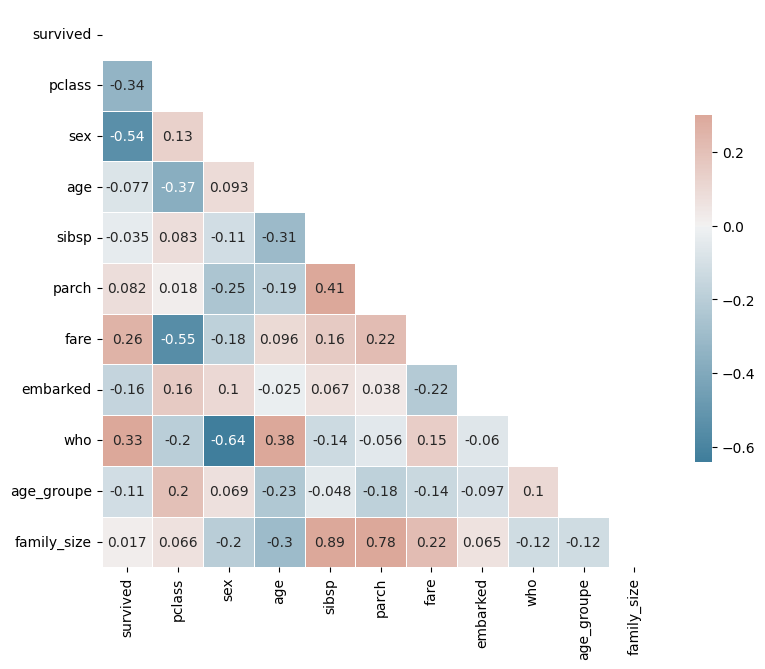

In [62]:
corr = del_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(9, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [63]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,age_groupe,family_size
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,young,1
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,adult,1
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,young,0
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,adult,1
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,adult,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True,young,0
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True,young,0
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False,NaN,3
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True,young,0


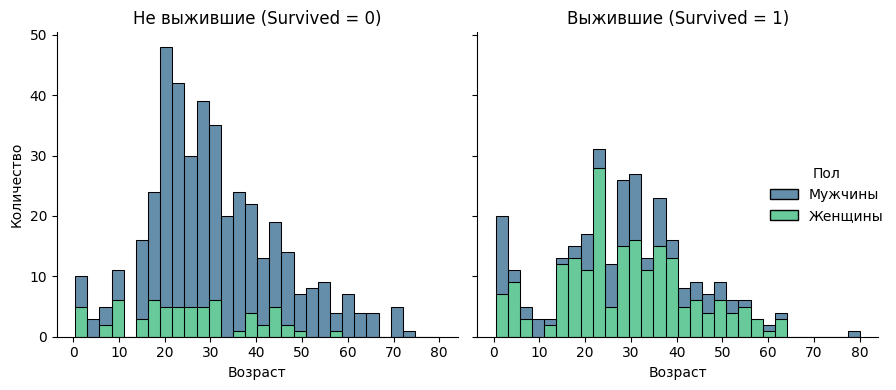

In [134]:
g = sns.displot(
    data=df,
    x='age',
    hue='sex',
    col='survived',
    kind='hist',
    multiple='stack',
    bins=30,
    palette='viridis',
    height=4,
    facet_kws={'sharey': True}  # Чтобы шкала Y была независимой для каждой панели
)


axes = g.axes.flatten()
axes[0].set_title('Не выжившие (Survived = 0)')
axes[1].set_title('Выжившие (Survived = 1)')
g.set_axis_labels('Возраст', 'Количество')
g.legend.set_title('Пол')
new_labels = ['Мужчины', 'Женщины']
for text, label in zip(g.legend.texts, new_labels):
    text.set_text(label)
plt.tight_layout()
plt.show()

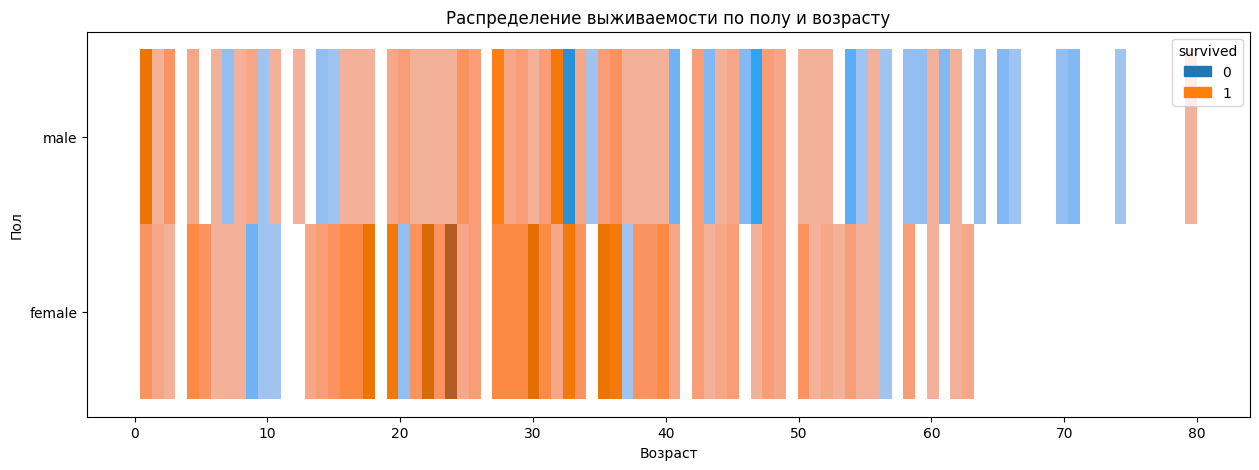

In [98]:
plt.figure(figsize=(15, 5))
g = sns.histplot(df, x="age", y="sex", hue="survived", bins=90)
g.set_title('Распределение выживаемости по полу и возрасту')
g.set_xlabel('Возраст')
g.set_ylabel('Пол')
plt.show()

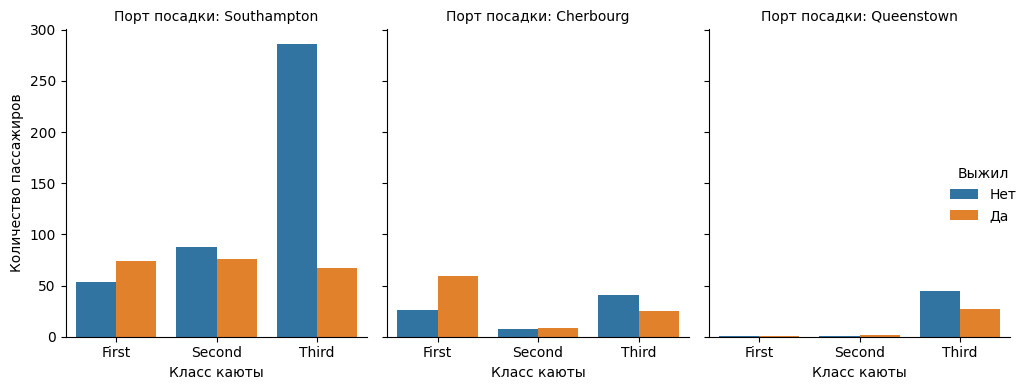

In [111]:
# Данные должны быть в DataFrame df
g = sns.catplot(
    df,
    x='class',
    hue='survived',
    col='embark_town',
    kind='count',
    dodge=True,
    height=4,
    aspect=0.8
)

# Настройка подписей осей для каждого подграфика
g.set_axis_labels('Класс каюты', 'Количество пассажиров')
g.set_titles('Порт посадки: {col_name}')  # Заголовок подграфика
g.legend.set_title('Выжил')
# Переименование меток в легенде для наглядности
new_labels = ['Нет', 'Да']
for text, label in zip(g.legend.texts, new_labels):
    text.set_text(label)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Класс каюты')

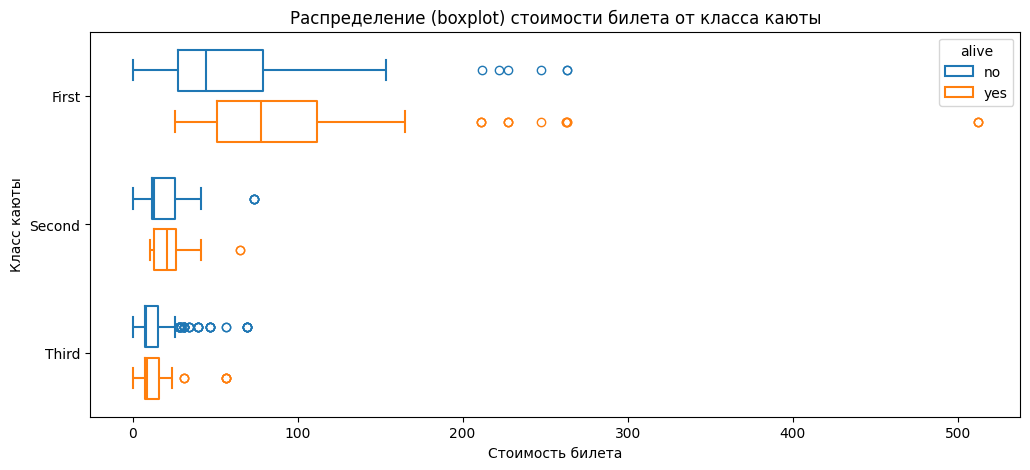

In [126]:
plt.figure(figsize=(12, 5))
g = sns.boxplot(df, x="fare", y="class", hue="alive", fill=False, gap=.2)
g.set_title('Распределение (boxplot) стоимости билета от класса каюты')
g.set_xlabel('Стоимость билета')
g.set_ylabel('Класс каюты')

In [150]:
def create_interactive_dashboard(df, age_from=18, age_to=60, pclass=[1, 2, 3]):
    fig = plt.figure(figsize=(15, 10))
    filtered_df = df[
        (df['age'].between(age_from, age_to)) &
        (df['pclass'].isin(pclass))
    ]
    gs = GridSpec(2, 3, figure=fig)

    fig_ax_1 = fig.add_subplot(gs[0, :])
    sns.countplot(data=filtered_df, x='embarked', palette='Set3', ax=fig_ax_1)
    fig_ax_1.set_title('Распределение по порту посадки')

    fig_ax_2 = fig.add_subplot(gs[1, 0])
    sns.countplot(data=filtered_df, x='pclass', hue='survived',
                  palette={0: 'red', 1: 'green'}, ax=fig_ax_2)
    fig_ax_2.set_title('Выживаемость по классам кают')
    fig_ax_2.set_xlabel('Класс каюты')
    fig_ax_2.set_ylabel('Количество пассажиров')
    fig_ax_2.legend(title='Выжил', labels=['Нет', 'Да'])

    fig_ax_3 = fig.add_subplot(gs[1, 1])
    gender_counts = filtered_df['sex'].value_counts()
    colors = ['lightblue', 'lightpink']
    fig_ax_3.pie(gender_counts.values, labels=gender_counts.index,
                 autopct='%1.1f%%', colors=colors, startangle=90)
    fig_ax_3.set_title('Распределение по полу')
    fig_ax_3.axis('equal')  # Чтобы круг был кругом

    fig_ax_4 = fig.add_subplot(gs[1, 2])
    sns.scatterplot(data=filtered_df, x='age', y='fare', hue='survived',
                alpha=0.6, ax=fig_ax_4, palette={0: 'red', 1: 'green'})
    fig_ax_4.set_title('Возраст vs Стоимость билета')

    plt.suptitle(f'Панель Titanic: Возраст {age_from}-{age_to}, Классы {pclass}',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()
    plt.show()

C:\Users\vl4xd\AppData\Local\Temp\ipykernel_20056\4005979931.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




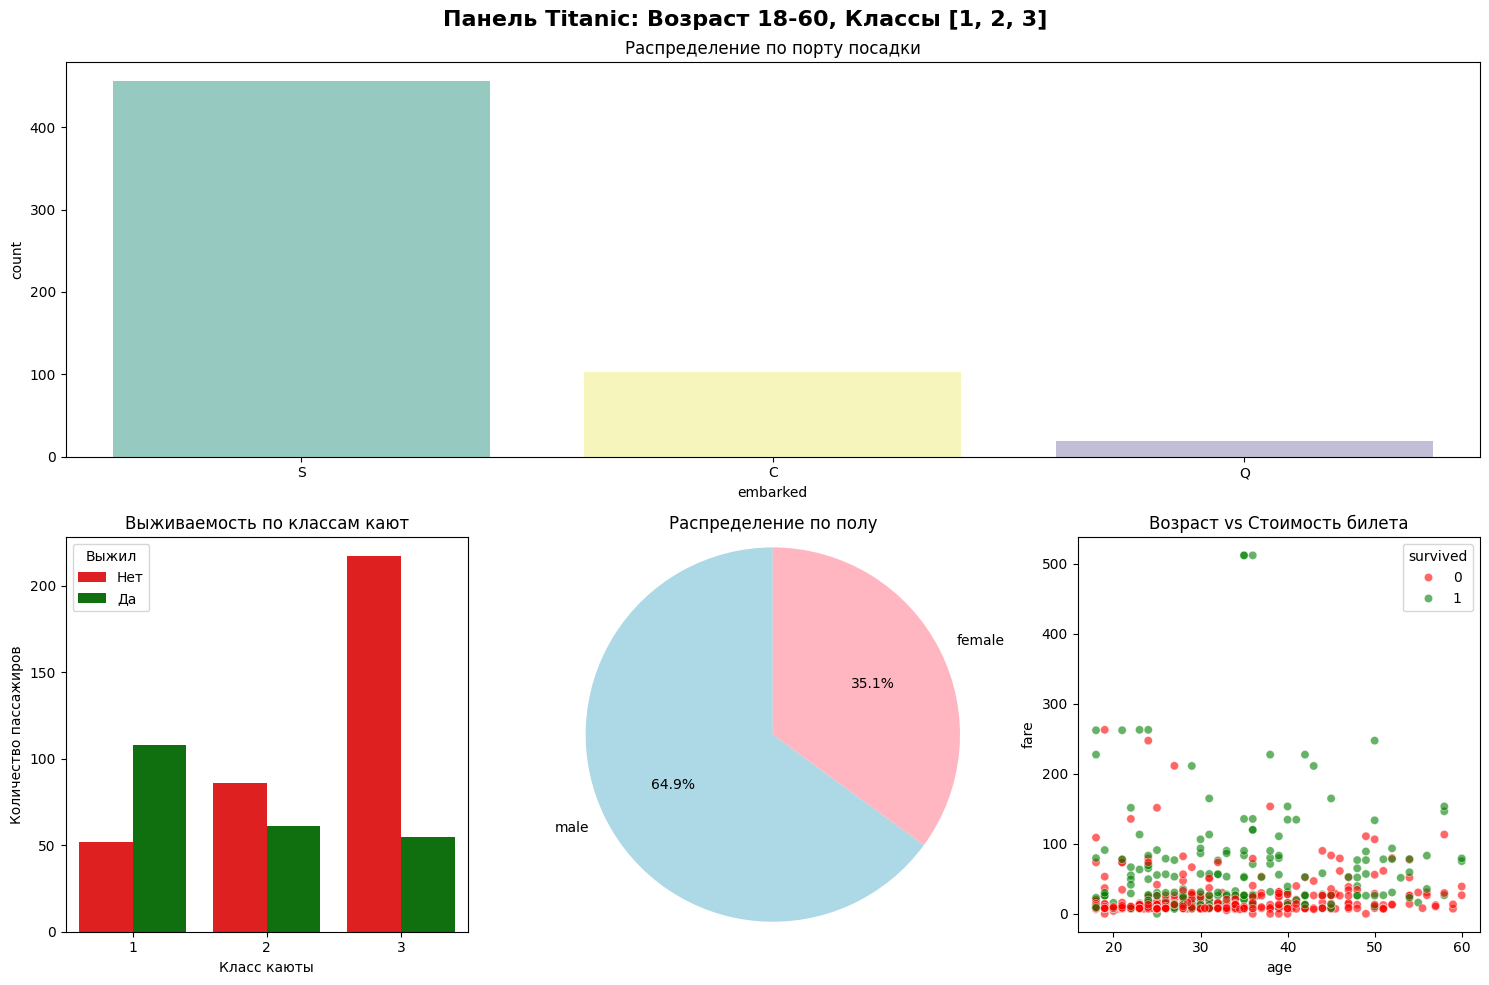

In [151]:
create_interactive_dashboard(df)

### Задание 3. Переход от NumPy/pandas на Polars и оптимизация больших данных

In [3]:
def generate_large_dataset(n_rows=1000000, engine=''):
    path = './data/large_dataset.csv'

    if not os.path.exists(path):
        pd.DataFrame({
            'id': range(n_rows),
            'timestamp': pd.date_range('2020-01-01', periods=n_rows, freq='1min'),
            'category': np.random.choice(['A', 'B', 'C', 'D'], n_rows),
            'value1': np.random.normal(0, 1, n_rows),
            'value2': np.random.exponential(1, n_rows),
            'value3': np.random.randint(0, 100, n_rows)
            }).to_csv(path, index=False)

    match engine:
        case 'pandas':
            return pd.read_csv(path, parse_dates=['timestamp'], index_col='timestamp')
        case 'pyarrow':
            return pd.read_csv(path, parse_dates=['timestamp'], index_col='timestamp', engine='pyarrow', dtype_backend='pyarrow')
        case 'polars':
            return pl.read_csv(path, try_parse_dates=True)
        case _:
            return 'Выберите корректный параметр engine (pandas, pyarrow, polars)'

In [4]:
pd_df = generate_large_dataset(engine='pandas')
ar_df = generate_large_dataset(engine='pyarrow')
pl_df = generate_large_dataset(engine='polars')

In [5]:
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000000 entries, 2020-01-01 00:00:00 to 2021-11-25 10:39:00
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   id        1000000 non-null  int64  
 1   category  1000000 non-null  object 
 2   value1    1000000 non-null  float64
 3   value2    1000000 non-null  float64
 4   value3    1000000 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 45.8+ MB


In [6]:
ar_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 2020-01-01 00:00:00 to 2021-11-25 10:39:00
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype          
---  ------    --------------    -----          
 0   id        1000000 non-null  int64[pyarrow] 
 1   category  1000000 non-null  string[pyarrow]
 2   value1    1000000 non-null  double[pyarrow]
 3   value2    1000000 non-null  double[pyarrow]
 4   value3    1000000 non-null  int64[pyarrow] 
dtypes: double[pyarrow](2), int64[pyarrow](2), string[pyarrow](1)
memory usage: 42.9 MB


In [7]:
pl_df.head(5)

id,timestamp,category,value1,value2,value3
i64,datetime[μs],str,f64,f64,i64
0,2020-01-01 00:00:00,"""D""",-2.037482,0.697912,46
1,2020-01-01 00:01:00,"""C""",-0.761749,0.061308,87
2,2020-01-01 00:02:00,"""C""",-1.430629,0.10306,29
3,2020-01-01 00:03:00,"""A""",-1.442133,0.449865,16
4,2020-01-01 00:04:00,"""A""",-0.585621,0.790233,8


In [8]:
pd_df.head(1)

,id,category,value1,value2,value3
timestamp,,,,,
2020-01-01,0,D,-2.037482,0.697912,46


In [9]:
ar_df.head(1)

,id,category,value1,value2,value3
timestamp,,,,,
2020-01-01 00:00:00,0,D,-2.037482,0.697912,46


In [10]:
@benchmark
def pandas_analysis(df: pd.DataFrame):
    return df[df['value1'] > 0].groupby('category').agg(
        sum_value_2 = ('value2', 'sum'),
        avg_value_2 = ('value2', 'mean'),
        stg_value_2 = ('value2', 'std'),
        count = ('value2', 'count')
    ).sort_values('avg_value_2', ascending=False)

@benchmark
def polars_analysis(df: pl.DataFrame):
    return (df
            .filter(pl.col('value1') > 0)
            .group_by('category')
            .agg([
                pl.sum('value2').alias('sum_value_2'),
                pl.mean('value2').alias('avg_value_2'),
                pl.std('value2').alias('stg_value_2'),
                pl.count('value2').alias('count')
            ])
            .sort('avg_value_2', descending=True))

@benchmark
def pandas_join(df: pd.DataFrame):
    df = df.reset_index()
    df1 = df.filter(['id', 'category', 'value1'])
    df2 = df.filter(['id', 'value2'])
    df3 = df.filter(['id', 'value3'])
    return df1.join(df2, on='id', how='left', rsuffix='_df2').join(df3, on='id', how='left', rsuffix='_df3')

@benchmark
def polars_join(df: pl.DataFrame):
    df1 = df.select(['id', 'category', 'value1'])
    df2 = df.select(['id', 'value2'])
    df3 = df.select(['id', 'value3'])
    return df1.join(df2, on='id', how='left', suffix='_df2').join(df3, on='id', how='left', suffix='_df3')

@benchmark
def pandas_rollavg(df: pd.DataFrame):
    return df['value3'].rolling(5).mean()

@benchmark
def polars_rollavg(df: pl.DataFrame):
    return df['value3'].rolling_mean(5)

@benchmark
def pandas_resampling(df: pd.DataFrame):
    return df['value3'].resample('h').mean()

@benchmark
def polars_resampling(df: pl.DataFrame):
    return df.group_by_dynamic('timestamp', every='1h').agg(pl.mean('value3'))

In [11]:
a = {'a':1, 'b':1}
list(a.items())

[('a', 1), ('b', 1)]

In [12]:
def benchmark_pandas_pyarrow_polars(pd_df: pd.DataFrame, ar_df: pd.DataFrame, pl_df: pl.DataFrame, num_repeat = 3):

    operations = [
        (pandas_analysis, polars_analysis),
        (pandas_join, polars_join),
        (pandas_rollavg, polars_rollavg),
        (pandas_resampling, polars_resampling)
    ]

    versions = ['pandas', 'pandas_pyarrow', 'polars']

    rows = []
    for version in versions:
        for pd_operation, pl_operation in operations:
            match version:
                case 'pandas':
                    operation_name = pd_operation.__name__.split('_')[-1]
                    res = [pd_operation(pd_df) for _ in range(num_repeat)]
                case 'pandas_pyarrow':
                    operation_name = pd_operation.__name__.split('_')[-1]
                    res = [pd_operation(ar_df) for _ in range(num_repeat)]
                case 'polars':
                    operation_name = pl_operation.__name__.split('_')[-1]
                    res = [pl_operation(pl_df) for _ in range(num_repeat)]

            rows.append({
                'version': version,
                'operation': operation_name,
                'avg_time': reduce(lambda aggr, x: aggr + x['time'], res, 0.0) / num_repeat,
                'avg_memory': reduce(lambda aggr, x: aggr + x['max_memory'], res, 0.0) / num_repeat
            })
            print(rows[-1])

    return pd.DataFrame(rows)

In [16]:
benchmark_pandas_pyarrow_polars_df = benchmark_pandas_pyarrow_polars(pd_df, ar_df, pl_df)

{'version': 'pandas', 'operation': 'analysis', 'avg_time': 0.07426333427429199, 'avg_memory': 620.359375}
{'version': 'pandas', 'operation': 'join', 'avg_time': 0.49120481808980304, 'avg_memory': 851.9440104166666}
{'version': 'pandas', 'operation': 'rollavg', 'avg_time': 0.04035798708597819, 'avg_memory': 635.2122395833334}
{'version': 'pandas', 'operation': 'resampling', 'avg_time': 0.030177195866902668, 'avg_memory': 603.6302083333334}
{'version': 'pandas_pyarrow', 'operation': 'analysis', 'avg_time': 0.06488426526387532, 'avg_memory': 620.4075520833334}
{'version': 'pandas_pyarrow', 'operation': 'join', 'avg_time': 0.39757831891377765, 'avg_memory': 704.4622395833334}
{'version': 'pandas_pyarrow', 'operation': 'rollavg', 'avg_time': 0.042236010233561196, 'avg_memory': 660.6458333333334}
{'version': 'pandas_pyarrow', 'operation': 'resampling', 'avg_time': 0.059877475102742515, 'avg_memory': 646.1809895833334}
{'version': 'polars', 'operation': 'analysis', 'avg_time': 0.0281471411387

In [17]:
benchmark_pandas_pyarrow_polars_df

,version,operation,avg_time,avg_memory
0,pandas,analysis,0.074263,620.359375
1,pandas,join,0.491205,851.944010
2,pandas,rollavg,0.040358,635.212240
3,pandas,resampling,0.030177,603.630208
4,pandas_pyarrow,analysis,0.064884,620.407552
5,pandas_pyarrow,join,0.397578,704.462240
6,pandas_pyarrow,rollavg,0.042236,660.645833
7,pandas_pyarrow,resampling,0.059877,646.180990
8,polars,analysis,0.028147,630.441406
9,polars,join,0.116280,796.790365


In [19]:
# Создаем график для времени выполнения
fig_time = go.Figure()

# Цвета для функций
colors = {
    'analysis': '#FF6B6B',
    'join': '#4ECDC4',
    'rollavg': '#FFD166',
    'resampling': '#06D6A0',
}

# Добавляем trace для каждой функции
for func in benchmark_pandas_pyarrow_polars_df['operation'].unique():
    func_data = benchmark_pandas_pyarrow_polars_df[benchmark_pandas_pyarrow_polars_df['operation'] == func]
    fig_time.add_trace(go.Bar(
        name=func,
        x=func_data['version'],
        y=func_data['avg_time'],
        marker_color=colors.get(func, 'gray'),
        text=[f'{t:.6f}' for t in func_data['avg_time']],
        textposition='auto',
    ))

fig_time.update_layout(
    title='Время выполнения функций для используемой версии',
    xaxis_title='Размер данных',
    yaxis_title='Время (сек)',
    barmode='group',
    height=600,
    showlegend=True
)

fig_time.show()

In [20]:
# Создаем график памяти на выполнение
fig_time = go.Figure()

# Цвета для функций
colors = {
    'analysis': '#FF6B6B',
    'join': '#4ECDC4',
    'rollavg': '#FFD166',
    'resampling': '#06D6A0',
}

# Добавляем trace для каждой функции
for func in benchmark_pandas_pyarrow_polars_df['operation'].unique():
    func_data = benchmark_pandas_pyarrow_polars_df[benchmark_pandas_pyarrow_polars_df['operation'] == func]
    fig_time.add_trace(go.Bar(
        name=func,
        x=func_data['version'],
        y=func_data['avg_memory'],
        marker_color=colors.get(func, 'gray'),
        text=[f'{t:.6f}' for t in func_data['avg_memory']],
        textposition='auto',
    ))

fig_time.update_layout(
    title='Затраты помяти на выполнение функции для используемой версии',
    xaxis_title='Размер данных',
    yaxis_title='Время (сек)',
    barmode='group',
    height=600,
    showlegend=True
)

fig_time.show()